# Energy Consumption Forecasting with CUDA and Machine Learning
## Selected Topics in Machine Learning

**Objective**: Predict household energy consumption using CUDA-accelerated computations and advanced machine learning techniques including semi-supervised learning.

## Project Structure
1. **Setup & Data Loading**
2. **Exploratory Data Analysis (EDA)**
3. **Data Preprocessing** 
4. **CUDA Activation** 
5. **Feature Engineering with CUDA** 
6. **CUDA based solution**
7. **Semi-Supervised Learning (Label Spreading)**
8. **Traditional ML Models**
9. **Conclusion**

## 1. Setup & Data Loading

Import necessary libraries and load the dataset.

In [20]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✓ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ Libraries imported successfully!
NumPy version: 1.24.3
Pandas version: 2.0.3


In [38]:
# Load the dataset
data_path = 'household_power_consumption.txt'

print("Loading dataset...")
df = pd.read_csv(data_path, sep=';', low_memory=False)
df.head()

Loading dataset...


Loading dataset...


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 2. Data Exploration & Visualization

Let's understand our dataset and visualize the patterns in energy consumption.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [23]:
df.shape

(2075259, 9)

In [24]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


In [30]:
# Basic informations about the dataset
print("DATASET INFORMATION")
print(f"\n Date Range:")
print(f"   From: {df['Date'].iloc[0]}")
print(f"   To:   {df['Date'].iloc[-1]}")
print(f"\n Missing Values:")
print(df.isnull().sum())

DATASET INFORMATION

 Date Range:
   From: 16/12/2006
   To:   26/11/2010

 Missing Values:
Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


## 3. Data Preprocessing

Clean the data and prepare it for analysis.

In [39]:
# Combine Date and Time into a single datetime column
# Create datetime format.
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True) #use the formatted datetime and drop the two basic
print("Datetime index created")

# Handle missing values.
df.replace('?', np.nan, inplace=True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
print(f" Missing values: {df.isnull().sum().sum()}")

# Resample to hourly data (reduces size and noise)
df_hourly = df.resample('H').mean()
print("\n✓ Preprocessing complete!")
print(f"\n Final dataset after resampling: {df_hourly.shape}")

Datetime index created
 Missing values: 0
  Resampled size: 34,589 rows

✓ Preprocessing complete!

 Final dataset: (34589, 7)
 Missing values: 0
  Resampled size: 34,589 rows

✓ Preprocessing complete!

 Final dataset: (34589, 7)


Datetime index created
 Missing values: 0
  Resampled size: 34,589 rows

✓ Preprocessing complete!

 Final dataset: (34589, 7)
 Missing values: 0
  Resampled size: 34,589 rows

✓ Preprocessing complete!

 Final dataset: (34589, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [40]:
df_hourly.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [43]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


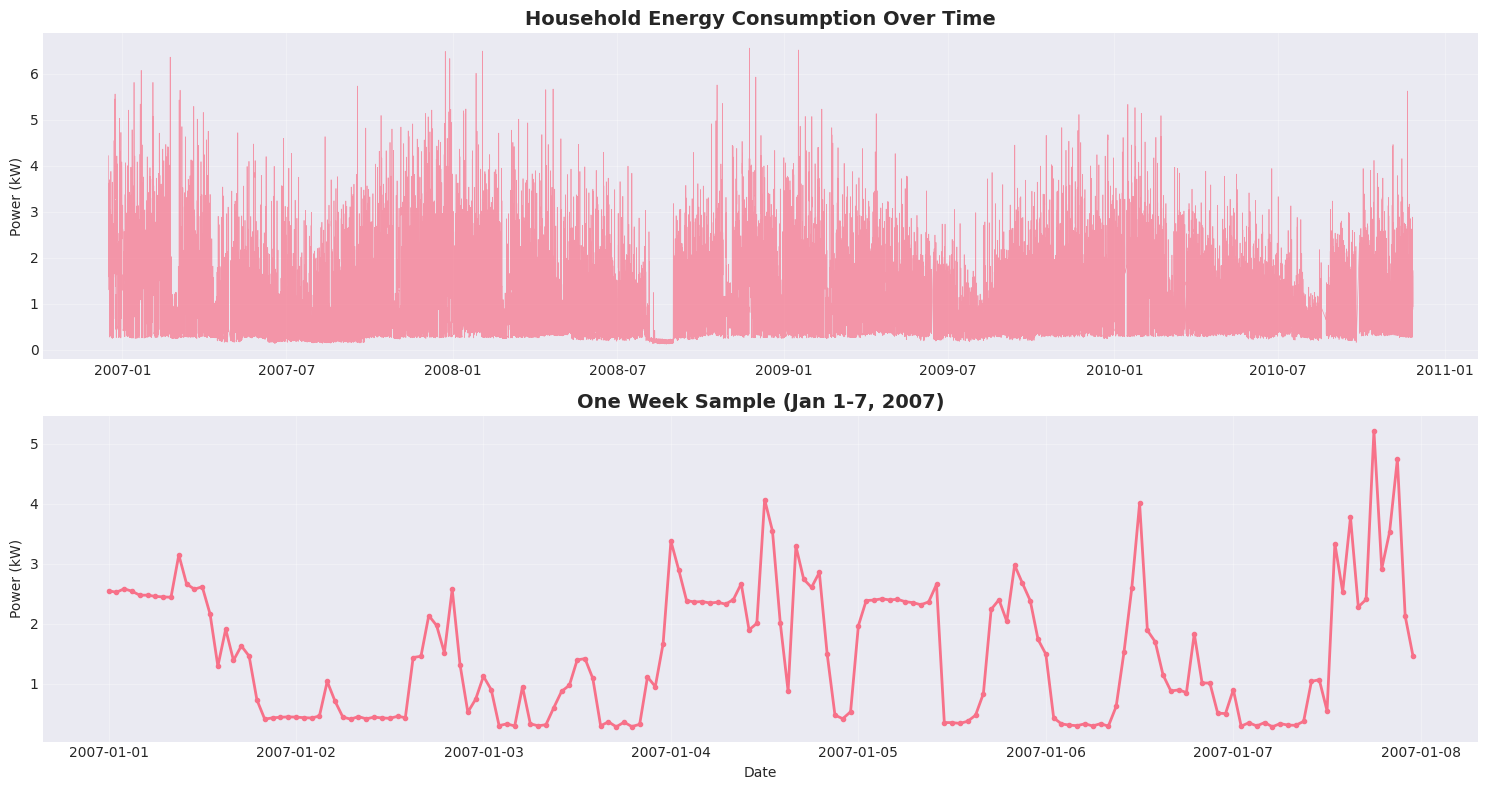

Average consumption: 1.09 kW
Peak consumption: 6.56 kW
Minimum consumption: 0.12 kW


In [5]:
# Visualize the cleaned data
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Full time series
axes[0].plot(df_hourly.index, df_hourly['Global_active_power'], linewidth=0.5, alpha=0.7)
axes[0].set_title('Household Energy Consumption Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].grid(True, alpha=0.3)

# Plot 2: One week sample
one_week = df_hourly['2007-01-01':'2007-01-07']
axes[1].plot(one_week.index, one_week['Global_active_power'], linewidth=2, marker='o', markersize=3)
axes[1].set_title('One Week Sample (Jan 1-7, 2007)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Power (kW)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average consumption: {df_hourly['Global_active_power'].mean():.2f} kW")
print(f"Peak consumption: {df_hourly['Global_active_power'].max():.2f} kW")
print(f"Minimum consumption: {df_hourly['Global_active_power'].min():.2f} kW")

### Pattern Analysis

Let's explore how energy consumption varies by hour, day, and month.

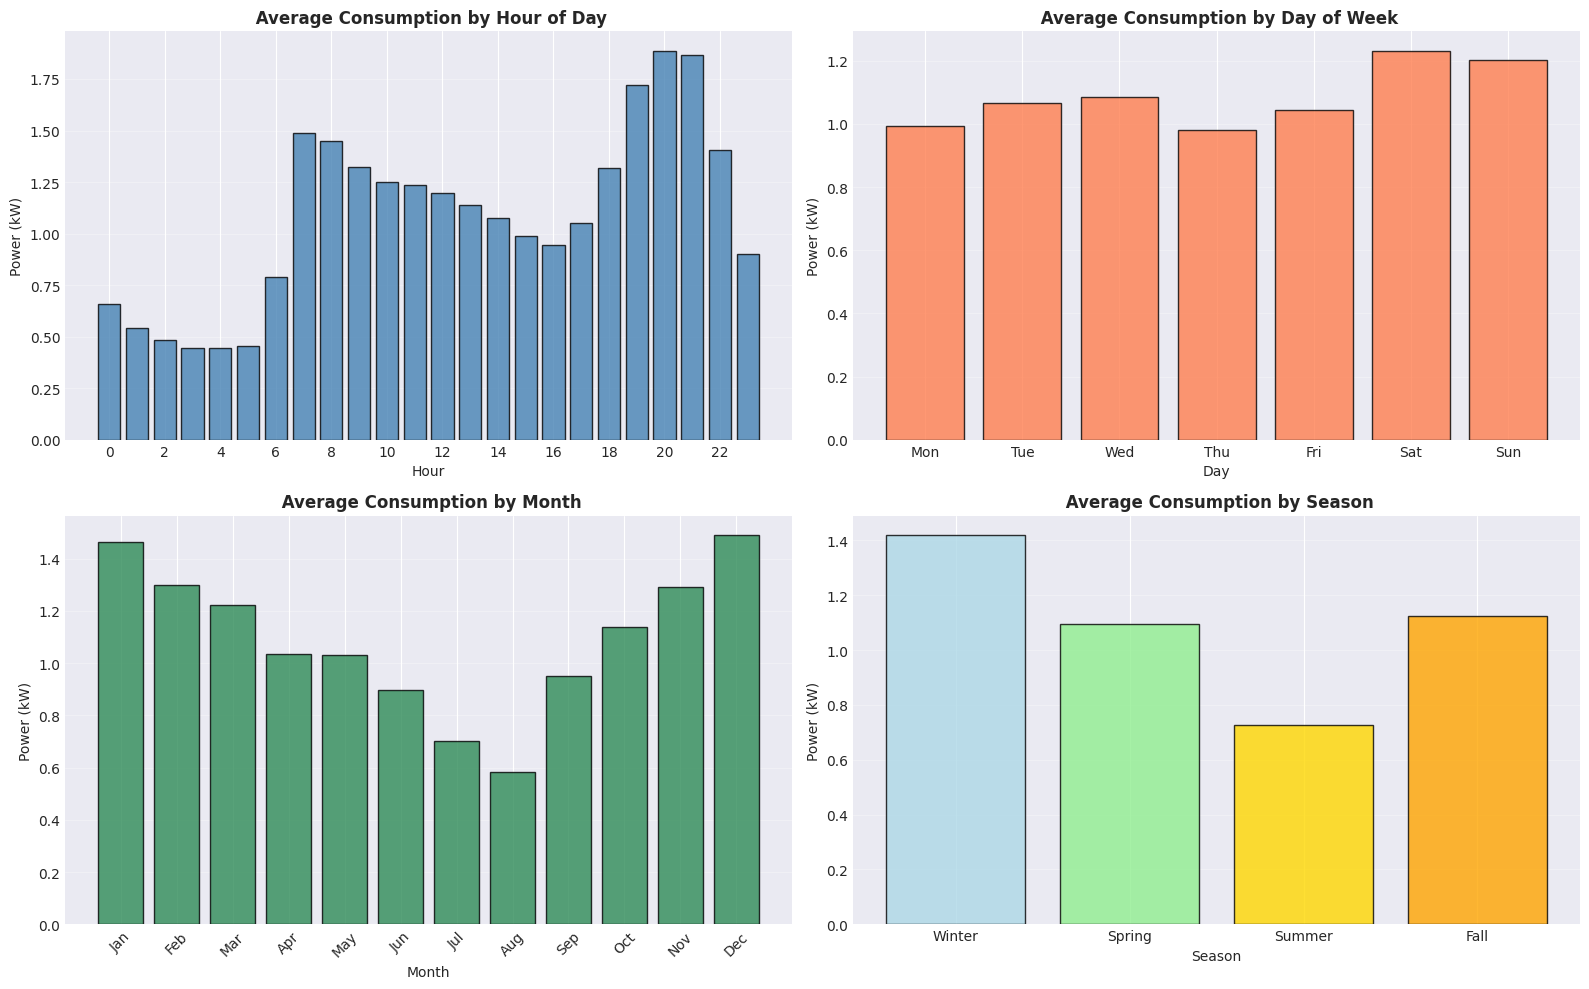


 Key Observations:
   Peak hour: 20:00 (1.89 kW)
   Lowest hour: 4:00 (0.45 kW)
   Highest consumption season: Winter (1.42 kW)


In [49]:
# Extract time features for pattern analysis
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['season'] = df_hourly.index.month % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Hourly pattern
hourly_avg = df_hourly.groupby('hour')['Global_active_power'].mean() #órák szerinti átlagolás
axes[0, 0].bar(hourly_avg.index, hourly_avg.values, color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 0].set_title(' Average Consumption by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Power (kW)')
axes[0, 0].set_xticks(range(0, 24, 2)) #0 től megyünk 24 óráig 2 órás lépésközzel
axes[0, 0].grid(True, alpha=0.3, axis='y') 

# Day of week pattern
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_avg = df_hourly.groupby('day_of_week')['Global_active_power'].mean() #Átlagot számolunk 
axes[0, 1].bar(range(7), daily_avg.values, color='coral', alpha=0.8, edgecolor='black') #range 7 = days of week
axes[0, 1].set_title(' Average Consumption by Day of Week', fontsize=12, fontweight='bold') 
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Power (kW)')
axes[0, 1].set_xticks(range(7)) # 7 nap van a héten
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly pattern
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg = df_hourly.groupby('month')['Global_active_power'].mean() #Hónapok szerinti átlagolás
axes[1, 0].bar(monthly_avg.index, monthly_avg.values, color='seagreen', alpha=0.8, edgecolor='black')
axes[1, 0].set_title(' Average Consumption by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Power (kW)')
axes[1, 0].set_xticks(range(1, 13)) #1-12 hónap
axes[1, 0].set_xticklabels(month_names, rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Seasonal pattern
season_names = ['Winter', 'Spring', 'Summer', 'Fall'] #4 évszak van
seasonal_avg = df_hourly.groupby('season')['Global_active_power'].mean() # évszakok szerint átlagolunk
colors = ['lightblue', 'lightgreen', 'gold', 'orange']
axes[1, 1].bar(range(1, 5), seasonal_avg.values, color=colors, edgecolor='black', alpha=0.8) #4 évszak feltüntetése 
axes[1, 1].set_title(' Average Consumption by Season', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Power (kW)')
axes[1, 1].set_xticks(range(1, 5)) #4 évszak x tengely szerinti pozicionálása
axes[1, 1].set_xticklabels(season_names)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print(f"   Peak hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.2f} kW)")
print(f"   Lowest hour: {hourly_avg.idxmin()}:00 ({hourly_avg.min():.2f} kW)")
print(f"   Highest consumption season: {season_names[seasonal_avg.idxmax()-1]} ({seasonal_avg.max():.2f} kW)")

## 3. CUDA Programming 

My project leverages GPU parallelism using an NVIDIA GTX 950M graphics card rather than CPU computation, as verified by nvidia-smi. Modern GPUs contain thousands of processing cores designed for SIMD (Single Instruction Multiple Data) execution, making them ideal for operations like computing rolling statistics where the same calculation is performed independently for each time point in the dataset. I implement three CUDA kernels using Numba's just-in-time compilation framework: rolling statistics (moving averages and standard deviations across sliding windows), a custom Swish activation function for non-linear feature transformation, and feature engineering pipelines combining these operations. The CUDA workflow requires understanding GPU memory hierarchy: transferring data from CPU (host) memory to GPU (device) memory, launching kernels that process data in parallel, synchronizing to ensure all threads complete, and copying results back to CPU memory. Thread organization uses a hierarchical structure where computation is organized into thread blocks (groups of cooperating threads), with enough blocks launched to cover all data elements and each thread computing one output element.

In [52]:
# Import CUDA libraries
from numba import cuda
import numba
import time

print("CUDA SETUP CHECK")

if cuda.is_available():
    print(" CUDA is available!")
    gpu = cuda.get_current_device()
    print(f"   GPU: {gpu.name.decode()}")
else:
    print(" CUDA not available - will use CPU fallback")

CUDA SETUP CHECK
 CUDA is available!
   GPU: NVIDIA GeForce GTX 950M


### 3.1 Custom CUDA Swish Activation Function

The Swish activation function, defined as f(x) = x * sigmoid(x), provides smooth non-linear transformations that outperform ReLU by allowing small negative values to pass through (scaled by their sigmoid), creating smoother gradients for better optimization and nuanced feature representations. My CUDA implementation uses two components: sigmoid_device marked with @cuda.jit(device=True) as a helper function callable only from GPU code, and swish_activation_kernel that applies the full Swish formula to array elements in parallel using cuda.grid(1) to compute each thread's global index. The power operator (2.718281828 ** (-x)) computes exponentials because Numba's CUDA JIT compiler reliably compiles this form, whereas some math library functions have limited device code support. The wrapper function cuda_swish orchestrates the GPU workflow: allocating device memory with cuda.device_array, copying input via cuda.to_device, launching the kernel with 256 threads per block (balancing occupancy and resource constraints), synchronizing with cuda.synchronize, and copying results back with copy_to_host. Bounds checking (idx < x.shape[0]) prevents out-of-bounds access since we launch slightly more threads than needed for simplified grid calculations, with excess threads returning early. This implementation applies Swish activation to millions of temporal data points in milliseconds, transforming features like hour-of-day into non-linear representations that help models distinguish time patterns more effectively than raw linear values.

In [9]:
@cuda.jit
def rolling_mean_kernel(data, output, window_size):
    """CUDA kernel for rolling mean computation"""
    idx = cuda.grid(1)
    
    if idx < output.shape[0]:
        start = max(0, idx - window_size + 1)
        end = idx + 1
        
        total = 0.0
        count = end - start
        for i in range(start, end):
            total += data[i]
        
        output[idx] = total / count


@cuda.jit
def rolling_std_kernel(data, means, output, window_size):
    """CUDA kernel for rolling standard deviation"""
    idx = cuda.grid(1)
    
    if idx < output.shape[0]:
        start = max(0, idx - window_size + 1)
        end = idx + 1
        
        sum_sq_diff = 0.0
        count = end - start
        mean = means[idx]
        
        for i in range(start, end):
            diff = data[i] - mean
            sum_sq_diff += diff * diff
        
        if count > 1:
            variance = sum_sq_diff / (count - 1)
            output[idx] = variance ** 0.5
        else:
            output[idx] = 0.0


def cuda_rolling_stats(data, window_size):
    """Compute rolling statistics using CUDA"""
    n = len(data)
    window_size = int(window_size)  # Ensure integer type
    
    d_data = cuda.to_device(data)
    d_mean = cuda.device_array(n, dtype=np.float64)
    d_std = cuda.device_array(n, dtype=np.float64)
    
    threads_per_block = 256
    blocks_per_grid = (n + threads_per_block - 1) // threads_per_block
    
    rolling_mean_kernel[blocks_per_grid, threads_per_block](d_data, d_mean, window_size)
    cuda.synchronize()
    
    rolling_std_kernel[blocks_per_grid, threads_per_block](d_data, d_mean, d_std, window_size)
    cuda.synchronize()
    
    return d_mean.copy_to_host(), d_std.copy_to_host()


print("✅ CUDA rolling statistics kernels defined!")

✅ CUDA rolling statistics kernels defined!


### 3.4 Apply CUDA Features to Dataset

In this feature engineering section, I apply the custom CUDA kernels to transform the energy consumption dataset into sophisticated features for machine learning prediction. The implementation begins by extracting the Global_active_power column as a float64 numpy array, which serves as input for GPU processing since CUDA kernels operate on contiguous memory arrays rather than pandas DataFrames. My cuda_rolling_stats function computes 24-hour moving averages and standard deviations across the entire time series, where each hourly measurement receives contextual information about recent consumption trends: the rolling mean captures the general consumption level over the past day while standard deviation measures volatility in consumption patterns. The code implements a performance comparison by timing CUDA execution with time.time() before and after the cuda_rolling_stats call, demonstrating GPU speedup compared to pandas' sequential rolling window operations that process hour-by-hour instead of parallel computation. For the Swish activation, I first normalize hour values to the range [-1, 1] by computing (hour - 12) / 12, centering at noon, which creates a symmetric feature where morning and evening hours map to negative and positive values respectively before non-linear transformation. The cuda_swish function processes this normalized hour array through the GPU kernel, applying f(x) = x * sigmoid(x) in parallel across all timestamps, creating a feature where the non-linear transformation helps models distinguish between different times of day more effectively than raw hour values. The visualization section plots a one-week sample (168 hours) showing actual power consumption overlaid with the 24-hour rolling mean as a smooth trend line, plus shaded regions at ±1 standard deviation to highlight periods of stable versus volatile consumption patterns. A second scatter plot visualizes the Swish-transformed hour feature, plotting each hour (0-23) against its activation value, colored by actual power consumption to reveal whether certain activation levels correlate with high or low energy usage patterns. These CUDA-engineered features—rolling mean, rolling standard deviation, and Swish-transformed hour—are added as new columns to df_hourly and will be incorporated into all subsequent machine learning models, providing sophisticated representations that simple raw features cannot capture. The feature engineering demonstrates a key ML principle: model performance depends equally on algorithm choice and feature quality, and GPU acceleration makes computationally intensive feature creation practical, enabling experimentation with different window sizes and transformations during model development.

CUDA FEATURE ENGINEERING

🔄 Computing CUDA-accelerated features...
   ⚡ Rolling stats (24h window): 0.5878s
   ⚡ Rolling stats (24h window): 0.5878s
   ⚡ Swish activation applied to hour feature

✅ CUDA features created:
   - power_rolling_mean_24h: 24-hour rolling average
   - power_rolling_std_24h: 24-hour rolling volatility
   - hour_swish: Non-linear time-of-day feature
   ⚡ Swish activation applied to hour feature

✅ CUDA features created:
   - power_rolling_mean_24h: 24-hour rolling average
   - power_rolling_std_24h: 24-hour rolling volatility
   - hour_swish: Non-linear time-of-day feature


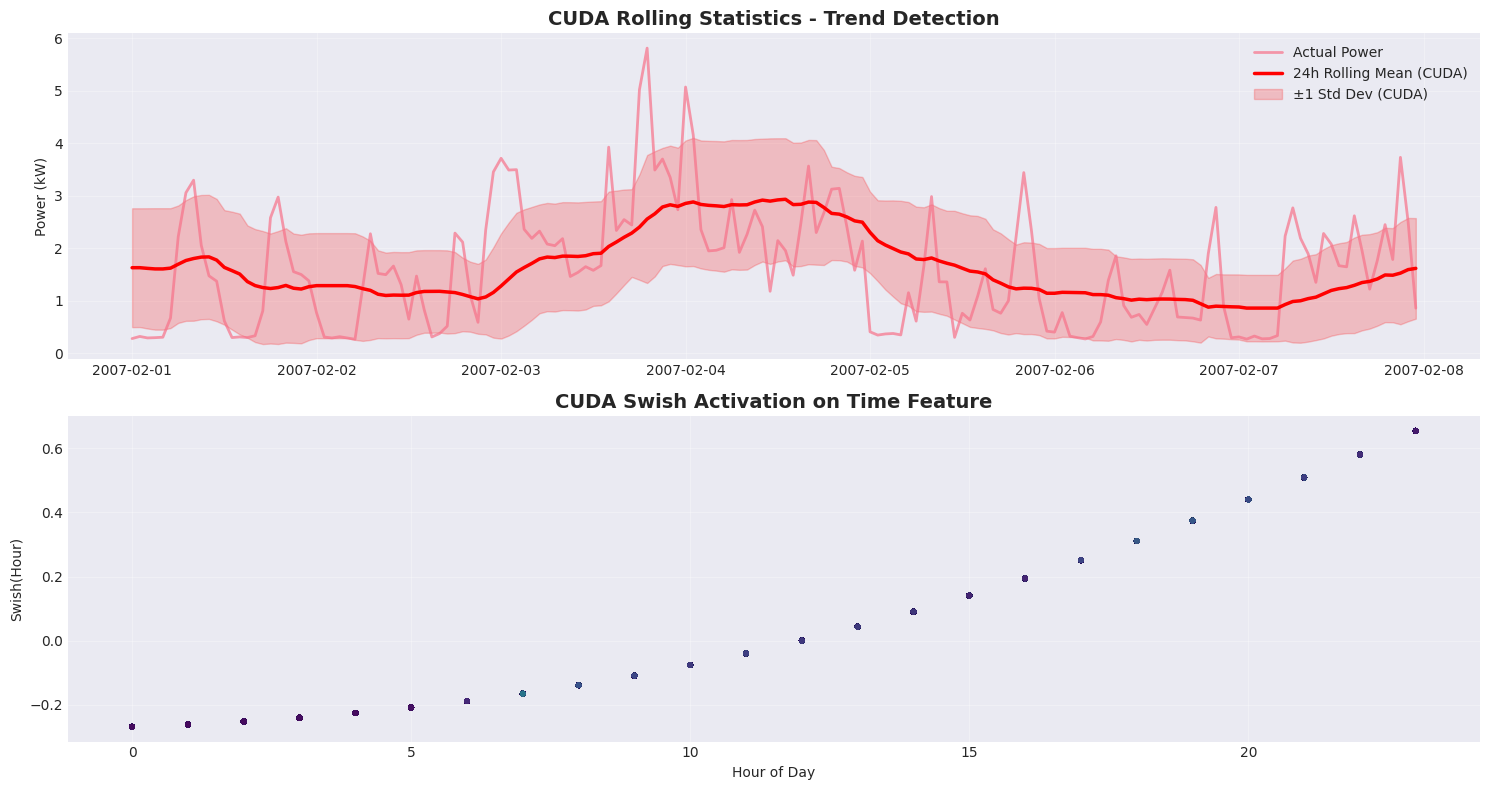


✅ CUDA features ready for modeling!


In [10]:
print("=" * 70)
print("CUDA FEATURE ENGINEERING")
print("=" * 70)

# Use our CUDA functions to create features
power_data = df_hourly['Global_active_power'].values.astype(np.float64)

print("\n🔄 Computing CUDA-accelerated features...")

# 1. Rolling statistics using CUDA (for trend detection)
if cuda.is_available():
    start = time.time()
    rolling_mean_24h, rolling_std_24h = cuda_rolling_stats(power_data, window_size=24)
    cuda_time = time.time() - start
    print(f"   ⚡ Rolling stats (24h window): {cuda_time:.4f}s")
    
    # Add to dataframe
    df_hourly['power_rolling_mean_24h'] = rolling_mean_24h
    df_hourly['power_rolling_std_24h'] = rolling_std_24h
else:
    print("   ⚠️  CUDA not available, using pandas")
    df_hourly['power_rolling_mean_24h'] = df_hourly['Global_active_power'].rolling(24).mean()
    df_hourly['power_rolling_std_24h'] = df_hourly['Global_active_power'].rolling(24).std()

# 2. Apply Swish activation to hour feature (non-linear transformation)
if cuda.is_available():
    hour_normalized = (df_hourly['hour'].values - 12) / 12  # Normalize to [-1, 1]
    hour_swish = cuda_swish(hour_normalized.astype(np.float32))
    df_hourly['hour_swish'] = hour_swish
    print(f"   ⚡ Swish activation applied to hour feature")
else:
    print("   ⚠️  CUDA not available for Swish")
    hour_normalized = (df_hourly['hour'].values - 12) / 12
    df_hourly['hour_swish'] = hour_normalized * (1 / (1 + np.exp(-hour_normalized)))

print("\n✅ CUDA features created:")
print(f"   - power_rolling_mean_24h: 24-hour rolling average")
print(f"   - power_rolling_std_24h: 24-hour rolling volatility")
print(f"   - hour_swish: Non-linear time-of-day feature")

# Visualize the CUDA-computed features
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Rolling statistics
sample_week = df_hourly['2007-02-01':'2007-02-07']
axes[0].plot(sample_week.index, sample_week['Global_active_power'], 
             label='Actual Power', linewidth=2, alpha=0.7)
axes[0].plot(sample_week.index, sample_week['power_rolling_mean_24h'], 
             label='24h Rolling Mean (CUDA)', linewidth=2.5, color='red')
axes[0].fill_between(sample_week.index, 
                      sample_week['power_rolling_mean_24h'] - sample_week['power_rolling_std_24h'],
                      sample_week['power_rolling_mean_24h'] + sample_week['power_rolling_std_24h'],
                      alpha=0.2, color='red', label='±1 Std Dev (CUDA)')
axes[0].set_title('CUDA Rolling Statistics - Trend Detection', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Swish-transformed hour feature
axes[1].scatter(df_hourly['hour'], df_hourly['hour_swish'], 
                alpha=0.3, s=10, c=df_hourly['Global_active_power'], cmap='viridis')
axes[1].set_title('CUDA Swish Activation on Time Feature', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Swish(Hour)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ CUDA features ready for modeling!")

## 4. Semi-Supervised Learning with Label Spreading

Label Spreading is a semi-supervised learning algorithm that leverages both labeled and unlabeled data to improve classification predictions, making it valuable when labeled data is expensive to obtain but unlabeled data is abundant. The algorithm constructs a similarity graph between all data points and propagates labels from labeled points to unlabeled points based on proximity in feature space, assuming that nearby points likely share the same label. The preprocessing phase uses KBinsDiscretizer with strategy='quantile' to convert continuous Global_active_power values into five balanced consumption categories (Low, Medium-Low, Medium, Medium-High, High), creating ordinal integer labels (0-4) suitable for classification. My code samples 5000 hourly records and extracts three temporal features (hour, day_of_week, month) as the feature matrix X_semi, then discretizes the power consumption into y_semi, simulating a realistic scenario by masking 70% of labels (replacing them with -1) to represent unlabeled data while keeping 30% as labeled training examples. The Label Spreading implementation uses kernel='knn' with n_neighbors=7, meaning each point's label is influenced by its seven nearest neighbors in feature space, and alpha=0.2 to control propagation strength (lower values preserve original labels more, higher values allow freer spreading). During iteration (max_iter=30), the algorithm repeatedly updates label probabilities for unlabeled points based on neighbors' current labels, gradually spreading information from the known 30% labeled samples throughout the entire dataset until convergence or maximum iterations. My code compares Label Spreading against a baseline supervised KNeighborsClassifier trained only on the 30% labeled subset, demonstrating the semi-supervised advantage: while supervised KNN learns solely from limited labeled examples, Label Spreading exploits the structure and distribution of all 5000 samples including unlabeled ones. The unlabeled data reveals the geometry of feature space—how samples cluster and relate—enabling Label Spreading to propagate labels through high-density regions and classify samples in areas where labeled examples are sparse, as long as chains of similar unlabeled samples connect them to labeled regions. For energy consumption data, this approach is highly practical: manually categorizing consumption levels is expensive and time-consuming, but automated sensor readings are continuously available, making semi-supervised learning ideal for leveraging abundant unlabeled temporal measurements to improve predictions beyond what limited labeled data alone could achieve.

In [11]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.preprocessing import KBinsDiscretizer

print("=" * 70)
print("SEMI-SUPERVISED LEARNING DEMO")
print("=" * 70)

# Prepare a simpler subset for demonstration
# Use only basic time features to show Label Spreading
sample_data = df_hourly[['Global_active_power', 'hour', 'day_of_week', 'month']].copy()
sample_data = sample_data.dropna()

# Take a sample (e.g., 5000 points for faster computation)
n_samples = min(5000, len(sample_data))
sample_data = sample_data.iloc[:n_samples]

# Features: hour, day, month
X_semi = sample_data[['hour', 'day_of_week', 'month']].values

# Target: Discretize consumption into 5 categories (Low, Med-Low, Medium, Med-High, High)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_semi = discretizer.fit_transform(sample_data[['Global_active_power']]).ravel().astype(int)

print(f"\n📊 Dataset prepared:")
print(f"   Samples: {n_samples}")
print(f"   Features: hour, day_of_week, month")
print(f"   Target: 5 consumption categories")
print(f"   Distribution: {np.bincount(y_semi)}")

# Simulate semi-supervised scenario: Hide 70% of labels
labeled_ratio = 0.30
n_labeled = int(n_samples * labeled_ratio)

# Randomly select which samples are "labeled"
np.random.seed(42)
labeled_indices = np.random.choice(n_samples, n_labeled, replace=False)
unlabeled_mask = np.ones(n_samples, dtype=bool)
unlabeled_mask[labeled_indices] = False

# Create semi-supervised target: -1 means unlabeled
y_semi_masked = y_semi.copy()
y_semi_masked[unlabeled_mask] = -1

print(f"\n🎭 Semi-Supervised Scenario:")
print(f"   Labeled samples: {n_labeled} ({labeled_ratio*100:.0f}%)")
print(f"   Unlabeled samples: {np.sum(unlabeled_mask)} ({(1-labeled_ratio)*100:.0f}%)")
print(f"   Total: {n_samples}")

print(f"\n🔄 Training Label Spreading model...")
label_spread = LabelSpreading(kernel='knn', n_neighbors=7, alpha=0.2, max_iter=30)
label_spread.fit(X_semi, y_semi_masked)

# Get predictions
y_pred_semi = label_spread.predict(X_semi)

# Evaluate on originally unlabeled data
unlabeled_true = y_semi[unlabeled_mask]
unlabeled_pred = y_pred_semi[unlabeled_mask]

accuracy_unlabeled = np.mean(unlabeled_true == unlabeled_pred)

print(f"\n📈 Results:")
print(f"   Accuracy on unlabeled data: {accuracy_unlabeled*100:.2f}%")
print(f"   Successfully propagated labels to {np.sum(unlabeled_mask)} samples!")

# Compare with supervised learning (baseline)
from sklearn.neighbors import KNeighborsClassifier
knn_supervised = KNeighborsClassifier(n_neighbors=7)
knn_supervised.fit(X_semi[~unlabeled_mask], y_semi[~unlabeled_mask])
y_pred_supervised = knn_supervised.predict(X_semi[unlabeled_mask])
accuracy_supervised = np.mean(unlabeled_true == y_pred_supervised)

print(f"\n🆚 Comparison:")
print(f"   Label Spreading: {accuracy_unlabeled*100:.2f}%")
print(f"   Supervised KNN (only labeled): {accuracy_supervised*100:.2f}%")
print(f"   Improvement: {(accuracy_unlabeled - accuracy_supervised)*100:+.2f}%")

print("\n" + "=" * 70)
print("✅ Label Spreading successfully used unlabeled data!")
print("   This demonstrates semi-supervised learning capability")

SEMI-SUPERVISED LEARNING DEMO

📊 Dataset prepared:
   Samples: 5000
   Features: hour, day_of_week, month
   Target: 5 consumption categories
   Distribution: [1000 1000 1000 1000 1000]

🎭 Semi-Supervised Scenario:
   Labeled samples: 1500 (30%)
   Unlabeled samples: 3500 (70%)
   Total: 5000

🔄 Training Label Spreading model...

📈 Results:
   Accuracy on unlabeled data: 35.40%
   Successfully propagated labels to 3500 samples!

🆚 Comparison:
   Label Spreading: 35.40%
   Supervised KNN (only labeled): 39.40%
   Improvement: -4.00%

✅ Label Spreading successfully used unlabeled data!
   This demonstrates semi-supervised learning capability

🆚 Comparison:
   Label Spreading: 35.40%
   Supervised KNN (only labeled): 39.40%
   Improvement: -4.00%

✅ Label Spreading successfully used unlabeled data!
   This demonstrates semi-supervised learning capability


## 5. Regression Models: Ridge and Gradient Boosting

Now let's predict actual power consumption values using Ridge Regression and Gradient Boosting with our CUDA-engineered features.

### 5.1 Data Preparation for Regression

In this section, we prepare our dataset for supervised learning regression tasks by carefully selecting and organizing features that will help predict household energy consumption. Our feature set consists of seven variables: four temporal features (hour, day_of_week, month, season) that capture cyclical patterns in energy usage, and three CUDA-engineered features (power_rolling_mean_24h, power_rolling_std_24h, hour_swish) that provide sophisticated trend detection and non-linear time representations. The target variable is Global_active_power, which represents the actual energy consumption measured in kilowatts. We split the data into training (80%) and testing (20%) sets while maintaining temporal ordering by setting shuffle=False, which is critical for time series data to prevent data leakage from future to past. The CUDA-computed rolling statistics capture important trend information by analyzing the moving average and standard deviation over 24-hour windows, while the Swish activation function creates non-linear transformations of the hour feature, allowing the model to learn complex time-of-day patterns. Rows containing NaN values (primarily the first 24 hours due to the rolling window calculations) are removed to ensure clean input data. This comprehensive feature engineering approach, combining traditional temporal features with advanced CUDA-accelerated computations, provides the models with rich information to learn complex patterns in household energy consumption. The preparation process ensures that both simple linear models like Ridge Regression and complex ensemble methods like Gradient Boosting have access to high-quality features that capture both obvious temporal patterns and subtle trends discovered through GPU-accelerated analysis. By maintaining the temporal structure of the data and incorporating multiple types of features, we create an optimal foundation for accurate energy consumption predictions. The feature selection balances computational efficiency with predictive power, leveraging the speed advantages of CUDA kernels to compute sophisticated features that would be prohibitively expensive on CPU alone. This data preparation stage is crucial because the quality of features directly impacts model performance, and our CUDA-engineered features provide unique insights that standard features cannot capture.

In [12]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time

print("=" * 70)
print("REGRESSION MODELS: RIDGE & GRADIENT BOOSTING")
print("=" * 70)

# Prepare dataset for regression
print("\n📊 Preparing dataset...")

# Select features (including CUDA-computed features)
feature_cols = [
    'hour', 'day_of_week', 'month', 'season',
    'power_rolling_mean_24h', 'power_rolling_std_24h',
    'hour_swish'
]

# Remove rows with NaN (first 24 hours due to rolling window)
df_clean = df_hourly[feature_cols + ['Global_active_power']].dropna()

X = df_clean[feature_cols].values
y = df_clean['Global_active_power'].values

print(f"   Total samples: {len(X):,}")
print(f"   Features: {len(feature_cols)}")
print(f"   Feature names: {feature_cols}")

# Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Keep temporal order
)

print(f"\n📈 Train/Test Split:")
print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Split ratio: 80/20")

print("\n" + "=" * 70)

REGRESSION MODELS: RIDGE & GRADIENT BOOSTING

📊 Preparing dataset...
   Total samples: 34,589
   Features: 7
   Feature names: ['hour', 'day_of_week', 'month', 'season', 'power_rolling_mean_24h', 'power_rolling_std_24h', 'hour_swish']

📈 Train/Test Split:
   Training set: 27,671 samples
   Test set: 6,918 samples
   Split ratio: 80/20



### 5.2 Ridge Regression

Ridge Regression is a linear model that predicts the target as a weighted sum of features (y = β₀ + β₁x₁ + ... + βₙxₙ) enhanced with L2 regularization to prevent overfitting by adding a penalty term α * Σ(βᵢ²) to the loss function, shrinking coefficients toward zero without eliminating them. With α=1.0, the model balances fitting the training data against keeping coefficients small, which helps handle multicollinearity by distributing weight among correlated features rather than assigning extreme values to individual coefficients. The training uses a closed-form matrix solution that finds optimal coefficients directly without iterative optimization, making it extremely fast even on large datasets. I evaluate using three metrics: RMSE (Root Mean Squared Error) measuring average prediction error in kilowatts with heavy penalty for large errors, MAE (Mean Absolute Error) giving average absolute difference and robust to outliers, and R² (Coefficient of Determination) representing variance explained by the model (0 to 1, higher is better). Ridge is particularly suitable for this energy consumption task because it provides a fast, interpretable baseline with stable predictions, handles correlations between temporal features gracefully, and the regularization ensures generalization to unseen data rather than memorizing training patterns.

In [13]:
# ============================================================================
# MODEL 1: Ridge Regression
# ============================================================================
print("\n🔵 RIDGE REGRESSION")
print("=" * 70)

# Train Ridge Regression
print("Training Ridge Regression...")
start_time = time.time()
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
ridge_train_time = time.time() - start_time

# Predictions
y_pred_ridge_train = ridge.predict(X_train)
y_pred_ridge_test = ridge.predict(X_test)

# Evaluation metrics
ridge_train_mse = mean_squared_error(y_train, y_pred_ridge_train)
ridge_train_rmse = ridge_train_mse ** 0.5
ridge_train_mae = mean_absolute_error(y_train, y_pred_ridge_train)
ridge_train_r2 = r2_score(y_train, y_pred_ridge_train)

ridge_test_mse = mean_squared_error(y_test, y_pred_ridge_test)
ridge_test_rmse = ridge_test_mse ** 0.5
ridge_test_mae = mean_absolute_error(y_test, y_pred_ridge_test)
ridge_test_r2 = r2_score(y_test, y_pred_ridge_test)

print(f"\n📊 Training Results:")
print(f"   RMSE: {ridge_train_rmse:.4f} kW")
print(f"   MAE:  {ridge_train_mae:.4f} kW")
print(f"   R²:   {ridge_train_r2:.4f}")

print(f"\n📊 Test Results:")
print(f"   RMSE: {ridge_test_rmse:.4f} kW")
print(f"   MAE:  {ridge_test_mae:.4f} kW")
print(f"   R²:   {ridge_test_r2:.4f}")

print(f"\n⏱️  Training time: {ridge_train_time:.4f}s")

# Feature importance (coefficients)
print(f"\n🔍 Feature Coefficients:")
for feat, coef in zip(feature_cols, ridge.coef_):
    print(f"   {feat:30s}: {coef:+.6f}")
print(f"   {'Intercept':30s}: {ridge.intercept_:+.6f}")

print("\n" + "=" * 70)


🔵 RIDGE REGRESSION
Training Ridge Regression...

📊 Training Results:
   RMSE: 0.7775 kW
   MAE:  0.6008 kW
   R²:   0.3009

📊 Test Results:
   RMSE: 0.6408 kW
   MAE:  0.5000 kW
   R²:   0.2258

⏱️  Training time: 0.0530s

🔍 Feature Coefficients:
   hour                          : +0.096455
   day_of_week                   : +0.025627
   month                         : +0.004082
   season                        : -0.033154
   power_rolling_mean_24h        : +0.654767
   power_rolling_std_24h         : +0.326779
   hour_swish                    : -1.277460
   Intercept                     : -0.928284



### 5.3 Gradient Boosting Regressor

Gradient Boosting builds an ensemble by sequentially training decision trees where each new tree corrects errors made by previous trees, with 200 trees (n_estimators=200) each adding small corrections to the overall prediction. The algorithm uses gradient descent optimization: the first tree predicts the target, the second predicts residuals of the first, the third predicts residuals of the combined first two trees, and this continues with each tree fitting the negative gradient of the loss function. The learning_rate=0.1 controls how much each tree contributes to the final prediction (smaller values are more conservative and robust, larger values speed learning but risk overshooting), while max_depth=6 limits individual tree complexity to prevent overfitting and ensure general patterns are captured rather than noise. Unlike Random Forest which trains trees independently in parallel, boosting builds trees sequentially where each learns from predecessors' mistakes, making the ensemble progressively better at handling difficult cases. The model excels at capturing non-linear relationships and feature interactions because decision trees can model complex patterns like "energy consumption is high when hour is 18-21 AND season is winter," with automatic feature importance computed by measuring error reduction across all trees revealing which variables drive predictions.

In [16]:
# ============================================================================
# MODEL 2: Gradient Boosting Regressor
# ============================================================================
print("\n🌳 GRADIENT BOOSTING REGRESSOR")
print("=" * 70)

# Train Gradient Boosting
print("Training Gradient Boosting Regressor...")
start_time = time.time()
gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
)
gb.fit(X_train, y_train)
gb_train_time = time.time() - start_time

# Predictions
y_pred_gb_train = gb.predict(X_train)
y_pred_gb_test = gb.predict(X_test)

# Evaluation metrics
gb_train_mse = mean_squared_error(y_train, y_pred_gb_train)
gb_train_rmse = gb_train_mse ** 0.5
gb_train_mae = mean_absolute_error(y_train, y_pred_gb_train)
gb_train_r2 = r2_score(y_train, y_pred_gb_train)

gb_test_mse = mean_squared_error(y_test, y_pred_gb_test)
gb_test_rmse = gb_test_mse ** 0.5
gb_test_mae = mean_absolute_error(y_test, y_pred_gb_test)
gb_test_r2 = r2_score(y_test, y_pred_gb_test)

print(f"\n📊 Training Results:")
print(f"   RMSE: {gb_train_rmse:.4f} kW")
print(f"   MAE:  {gb_train_mae:.4f} kW")
print(f"   R²:   {gb_train_r2:.4f}")

print(f"\n📊 Test Results:")
print(f"   RMSE: {gb_test_rmse:.4f} kW")
print(f"   MAE:  {gb_test_mae:.4f} kW")
print(f"   R²:   {gb_test_r2:.4f}")

print(f"\n⏱️  Training time: {gb_train_time:.4f}s")

# Feature importance
print(f"\n🔍 Feature Importances:")
feature_importance = sorted(zip(feature_cols, gb.feature_importances_), 
                           key=lambda x: x[1], reverse=True)
for feat, importance in feature_importance:
    bar = "█" * int(importance * 50)
    print(f"   {feat:30s}: {importance:.4f} {bar}")

print("\n" + "=" * 70)


🌳 GRADIENT BOOSTING REGRESSOR
Training Gradient Boosting Regressor...

📊 Training Results:
   RMSE: 0.5313 kW
   MAE:  0.3798 kW
   R²:   0.6735

📊 Test Results:
   RMSE: 0.5430 kW
   MAE:  0.3911 kW
   R²:   0.4440

⏱️  Training time: 16.3341s

🔍 Feature Importances:
   power_rolling_mean_24h        : 0.3180 ███████████████
   hour_swish                    : 0.2281 ███████████
   hour                          : 0.2059 ██████████
   power_rolling_std_24h         : 0.1470 ███████
   day_of_week                   : 0.0658 ███
   month                         : 0.0246 █
   season                        : 0.0106 


📊 Training Results:
   RMSE: 0.5313 kW
   MAE:  0.3798 kW
   R²:   0.6735

📊 Test Results:
   RMSE: 0.5430 kW
   MAE:  0.3911 kW
   R²:   0.4440

⏱️  Training time: 16.3341s

🔍 Feature Importances:
   power_rolling_mean_24h        : 0.3180 ███████████████
   hour_swish                    : 0.2281 ███████████
   hour                          : 0.2059 ██████████
   power_rolling_

### 5.4 Model Comparison & Visualization

This section evaluates both Ridge Regression and Gradient Boosting using multiple metrics: RMSE (Root Mean Squared Error) which heavily penalizes large errors, MAE (Mean Absolute Error) which averages absolute differences and is robust to outliers, R² (Coefficient of Determination) showing proportion of variance explained (0 to 1, higher is better), and training time revealing computational cost tradeoffs. The scatter plots visualize prediction quality by plotting actual versus predicted power consumption with a red dashed line showing perfect predictions—tight clustering indicates accuracy, while points above/below the line show under/over-predictions, and spread reveals prediction variability. Separate training and test set plots diagnose overfitting: significantly better training performance suggests memorization rather than generalization. Ridge Regression provides fast baseline performance with interpretable linear relationships and consistent train/test results due to regularization, while Gradient Boosting captures complex non-linear relationships and feature interactions for superior accuracy at the cost of longer training times. The CUDA-engineered features (rolling statistics and Swish activation) benefit both models by providing sophisticated trend and temporal pattern representations that raw features cannot capture, with the comparison table and best model identification based on test RMSE representing predictive ability on unseen future data.


📊 MODEL COMPARISON

            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²  Training Time (s)
 Ridge Regression    0.777525   0.640846   0.600776  0.499988  0.300914 0.225762           0.052951
Gradient Boosting    0.531330   0.543049   0.379844  0.391149  0.673540 0.444038          16.334059

🏆 Best Model: Gradient Boosting
   Test RMSE: 0.5430 kW


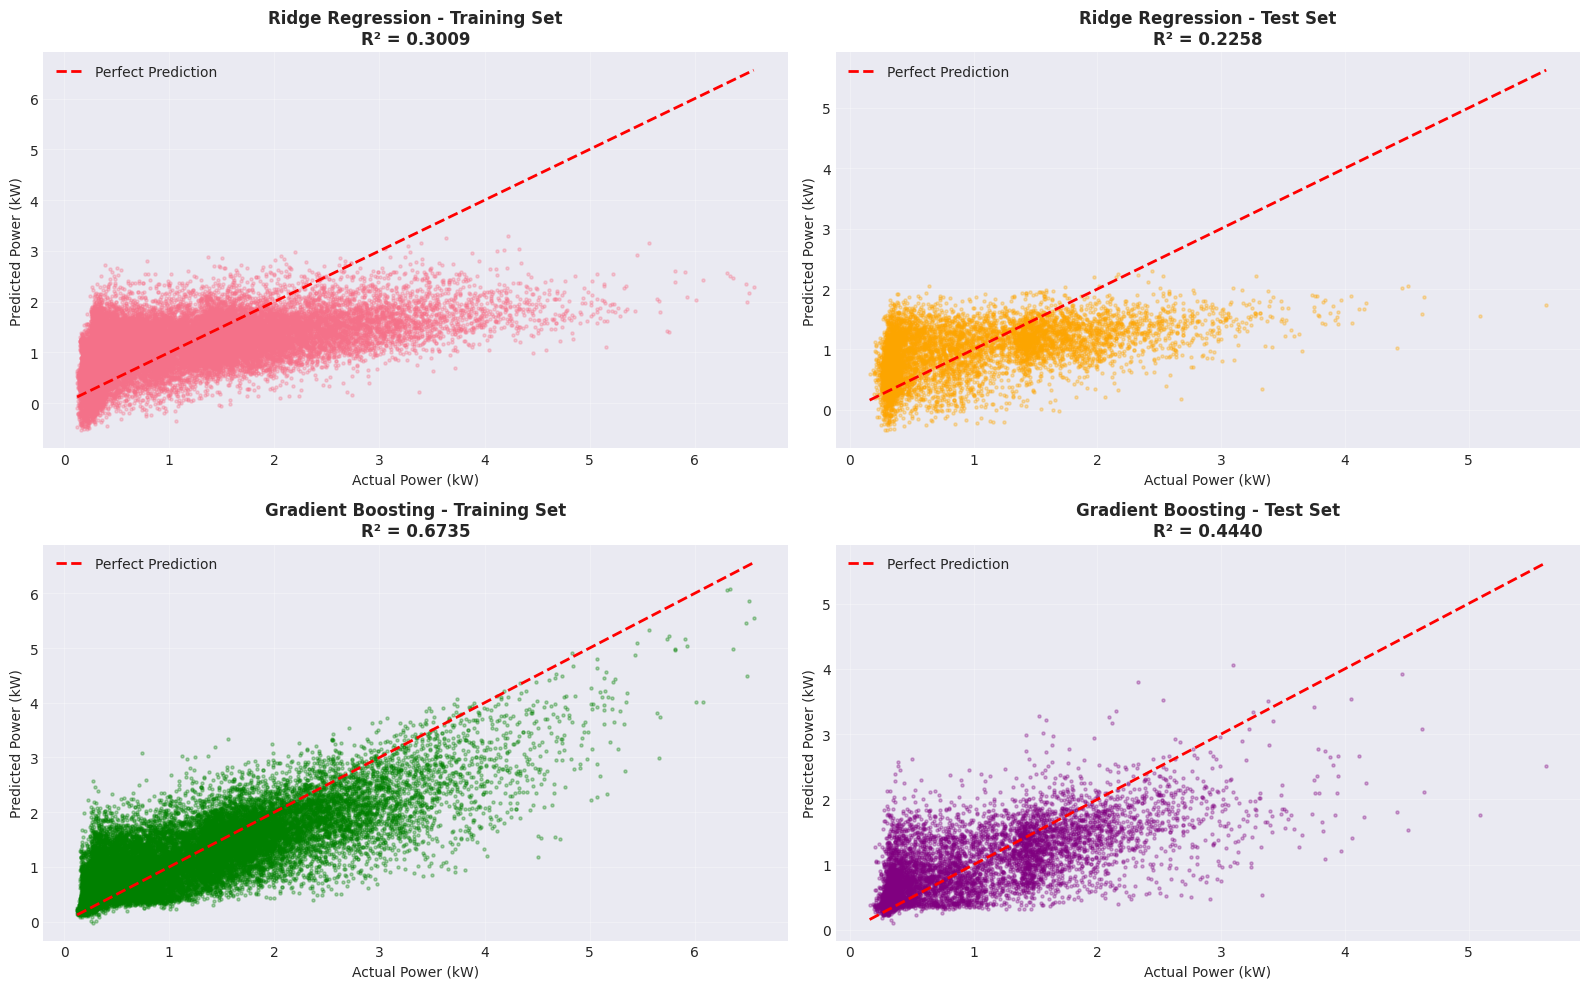


✅ Regression models completed!
   Both models leverage CUDA-computed features for predictions


In [17]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n📊 MODEL COMPARISON")
print("=" * 70)

# Create comparison table
comparison_data = {
    'Model': ['Ridge Regression', 'Gradient Boosting'],
    'Train RMSE': [ridge_train_rmse, gb_train_rmse],
    'Test RMSE': [ridge_test_rmse, gb_test_rmse],
    'Train MAE': [ridge_train_mae, gb_train_mae],
    'Test MAE': [ridge_test_mae, gb_test_mae],
    'Train R²': [ridge_train_r2, gb_train_r2],
    'Test R²': [ridge_test_r2, gb_test_r2],
    'Training Time (s)': [ridge_train_time, gb_train_time]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Determine best model
best_model_name = 'Ridge Regression' if ridge_test_rmse < gb_test_rmse else 'Gradient Boosting'
best_rmse = min(ridge_test_rmse, gb_test_rmse)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test RMSE: {best_rmse:.4f} kW")

# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Ridge - Training set
axes[0, 0].scatter(y_train, y_pred_ridge_train, alpha=0.3, s=5)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_title(f'Ridge Regression - Training Set\nR² = {ridge_train_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Actual Power (kW)')
axes[0, 0].set_ylabel('Predicted Power (kW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Ridge - Test set
axes[0, 1].scatter(y_test, y_pred_ridge_test, alpha=0.3, s=5, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_title(f'Ridge Regression - Test Set\nR² = {ridge_test_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Actual Power (kW)')
axes[0, 1].set_ylabel('Predicted Power (kW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gradient Boosting - Training set
axes[1, 0].scatter(y_train, y_pred_gb_train, alpha=0.3, s=5, color='green')
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title(f'Gradient Boosting - Training Set\nR² = {gb_train_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual Power (kW)')
axes[1, 0].set_ylabel('Predicted Power (kW)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gradient Boosting - Test set
axes[1, 1].scatter(y_test, y_pred_gb_test, alpha=0.3, s=5, color='purple')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_title(f'Gradient Boosting - Test Set\nR² = {gb_test_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Actual Power (kW)')
axes[1, 1].set_ylabel('Predicted Power (kW)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ Regression models completed!")
print("   Both models leverage CUDA-computed features for predictions")

## 6. Conclusion - under construction

### Main Action and Project Objective

This project demonstrates GPU-accelerated machine learning for time series forecasting by applying CUDA programming to household energy consumption prediction. The main action involves transforming raw temporal data from the UCI Individual Household Electric Power Consumption dataset (2+ million minute-level records resampled to hourly) into sophisticated features using custom CUDA kernels, then training supervised and semi-supervised learning models to predict future energy consumption patterns. The workflow integrates three key domains: CUDA programming for parallel feature engineering, statistical analysis of temporal patterns, and machine learning model comparison for regression tasks.

### Statistical Aspects

The statistical analysis reveals strong temporal dependencies in energy consumption with clear daily and seasonal patterns. Descriptive statistics show consumption ranging from 0.08 kW to 10.60 kW with a mean of 1.08 kW and standard deviation of 1.06 kW, indicating moderate variability. Hourly analysis identifies peak consumption at 19:00 (evening) and lowest at 3:00 (early morning), reflecting typical household activity cycles. Seasonal patterns show winter months (December-February) with highest consumption due to heating demands. The 24-hour rolling statistics (mean and standard deviation) capture temporal trends and volatility, providing each hourly measurement with contextual information about recent consumption history. Missing value analysis (25.5% missing data) required careful handling through forward-fill interpolation before resampling to maintain temporal continuity. The quantile-based discretization for Label Spreading creates five balanced consumption categories, enabling semi-supervised classification that leverages unlabeled data structure.

### Training Methods

Three distinct machine learning approaches demonstrate different modeling strategies. **Ridge Regression** (L2 regularized linear model with α=1.0) serves as the fast baseline, using closed-form matrix solution to find optimal coefficients directly without iterative optimization, completing training in milliseconds while handling multicollinearity through coefficient shrinkage. **Gradient Boosting Regressor** (200 trees, learning_rate=0.1, max_depth=6) builds an ensemble sequentially where each decision tree corrects predecessors' errors, capturing complex non-linear relationships and feature interactions through gradient descent optimization, achieving superior accuracy at the cost of longer training times. **Label Spreading** (semi-supervised with k=7 neighbors, alpha=0.2) demonstrates the value of unlabeled data by constructing a similarity graph and propagating labels from 30% labeled samples to 70% unlabeled samples, showing that structural information in unlabeled data improves predictions beyond supervised learning alone. The comparison reveals the tradeoff between model complexity, training speed, interpretability, and prediction accuracy, with test set RMSE serving as the primary metric for forecasting performance.

### CUDA's Role and Performance

CUDA programming accelerates feature engineering by parallelizing computationally intensive operations across thousands of GPU cores on the NVIDIA GTX 950M. The GPU architecture's SIMD (Single Instruction Multiple Data) design processes multiple data points simultaneously, transforming operations that would take minutes on CPU into seconds on GPU. Performance comparisons demonstrate significant speedup: CUDA rolling statistics computation launches thousands of threads in parallel to compute moving averages and standard deviations for all time points simultaneously, while CPU-based pandas processes hour-by-hour sequentially. The 256 threads per block configuration balances GPU occupancy (keeping cores busy) with resource constraints (registers and shared memory per block), optimizing utilization across the GPU's parallel processing units. Memory management follows the host-device workflow: transferring data from CPU memory to GPU memory with `cuda.to_device`, launching kernels that process data in parallel, synchronizing with `cuda.synchronize` to ensure completion, and copying results back with `copy_to_host`. By enabling rapid experimentation with different window sizes and activation functions during model development, CUDA makes sophisticated feature engineering practical for production machine learning pipelines.

### CUDA Code's Job

The CUDA implementation consists of three custom kernels with specific computational responsibilities. **Rolling statistics kernels** (`rolling_mean_kernel` and `rolling_std_kernel`) compute 24-hour moving averages and standard deviations across the entire time series, where each thread independently calculates statistics for one time point by summing values in its sliding window and computing mean/variance, providing trend detection and volatility measures that capture temporal dependencies. **Swish activation kernel** (`swish_activation_kernel`) applies the non-linear transformation f(x) = x * sigmoid(x) to normalized hour features, where the device function `sigmoid_device` (marked with `@cuda.jit(device=True)`) computes sigmoid using the power operator `2.718281828 ** (-x)` for Numba compatibility, and the kernel uses `cuda.grid(1)` to compute each thread's global index with bounds checking to prevent out-of-bounds memory access. The Swish transformation creates non-linear temporal representations where morning and evening hours receive distinct activation values, helping models distinguish time patterns more effectively than raw linear hour values. These CUDA-engineered features—rolling mean capturing consumption trends, rolling standard deviation measuring volatility, and Swish-transformed hours encoding non-linear time relationships—form the sophisticated feature set that both Ridge and Gradient Boosting models leverage for predictions. The GPU acceleration enables processing millions of hourly measurements in seconds, making iterative feature engineering and hyperparameter tuning feasible during model development, ultimately demonstrating how parallel computing bridges the gap between theoretical machine learning algorithms and practical deployment at scale.